In [1]:
# Imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import oledpy.dipole_emission as diem
from oledpy.dipole_emission import ThinFilmArchitecture
from numpy.lib.scimath import sqrt as csqrt
import warnings
warnings.filterwarnings('ignore')
df_nk=pd.read_csv(os.path.join('Reference Data','nk_library.csv'))

# Defining an Architecture

There are two general ways to define an architecture. The first is to define list variables for layer properties (names, thicknesses, index of refraction, etc.). Note that the doping property uses the assumption of an ideal mixture to calculate the refractive indices of a mixed layer from the indices of the pure components.

In [2]:
layer_names = ['SiO2','ITO','TCTA','CBP-Irppy','TPBi','Al','Air']
d = [0,100,35,30,40,100,0]
doping = [1,1,1,[0.92,0.08],1,1,1]

The other is to define a list of dictionaries, where each dict defines the property of a layer.
The "active" key is used to flag which layer is the emissive layer.

Note: Currently, the "coherent" key is not used. Eventually this will be used to calculate mixed coherent and incoherent stacks. 

In [3]:
layers = [
     {'name':'SiO2'      ,'d':0  ,'doping':1,'coherent':0},
     {'name':'ITO'       ,'d':100,'doping':1,'coherent':1},
     {'name':'TCTA'      ,'d':35 ,'doping':1,'coherent':1},
     {'name':'CBP-Irppy','d':30 ,'doping':[0.92,0.08],'coherent':1,'active':1},
     {'name':'TPBi'      ,'d':40 ,'doping':1,'coherent':1},
     {'name':'Al'        ,'d':100,'doping':1,'coherent':1},
     {'name':'Air'       ,'d':0  ,'doping':1,'coherent':0},
]

Next, import the photoluminescence spectrum, set the dipole positions, and load refractive indices.

In [4]:
wavelengths = np.arange(480,670,5)# Define wavelengths of interest
dipole_positions = [0.9] # dipole planes located near EML/ETL interface
irppy3_PL = np.genfromtxt(os.path.join("Reference Data",'irppy3_intrinsic_pl.csv'),skip_header=1,delimiter=',')
PL_interp = np.interp(wavelengths,irppy3_PL[:,0],irppy3_PL[:,1])
architecture = ThinFilmArchitecture(
    layer_dict_list = layers,
    dipole_positions = dipole_positions,
    tau=1e-6,PLQY=0.95, # Intrinsic exciton lifetime and PL quantum yield of Ir(ppy)3
    vac_wavelengths=wavelengths,pl_spectrum=PL_interp)
architecture.load_nk(df_nk=df_nk)
architecture.run_attribute_checks()

Active layer is: CBP-Irppy. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed


Note that refractive indices are loaded from "nk_library.csv". To add data to this library, simply paste interpolated data (300 to 800 nm in 1 nm steps) into columns names "material_n" and "material_k".

In [5]:
df_nk[['Wavelength (nm)','tpbi_n','tpbi_k']].head()

,Wavelength (nm),tpbi_n,tpbi_k
0,300.0,1.81184,0.55061
1,301.0,1.82532,0.55675
2,302.0,1.83881,0.56289
3,303.0,1.85376,0.56391
4,304.0,1.86871,0.56492


Now, calculate the power dissipation spectrum for this architecture.

In [6]:
# This grid of wavevectors provides a good balance
# between accuracy and calculation speed
custom_u = np.hstack((np.arange(0,0.75,0.005),
                      np.arange(0.75,1,0.001),
                      np.arange(1+0.001,2,0.002),
                      np.arange(2,10,0.1)))
architecture.init_pds_variables(custom_u=custom_u)

Provided imaginary active layer index. Discarding imaginary part.


In [7]:
architecture.calc_r_and_t()
K_data = architecture.calc_K()

# Power Dissipation Spectra

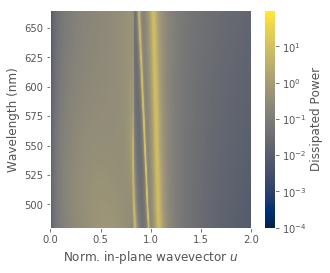

In [9]:
# 2D power dissipation plot
from matplotlib import colors, ticker, cm
with plt.style.context('ggplot'):
    fig,ax=plt.subplots(figsize=(4.5,4))
    u = architecture.u
    K_total_array = K_data['K_total']
    z = u*K_total_array[0,:,:]
    lev_exp = np.arange(-4,#np.floor(np.log10(z[z>0].min())-1)
                        np.ceil(np.log10(z.max())),0.01)
    levs = np.power(10, lev_exp)
    cs = ax.contourf(u,wavelengths, z, levs, 
                norm=colors.LogNorm(),cmap=plt.get_cmap('cividis'))#cividis,#plasma,#viridis
    ticks = 10**np.arange(-4,np.ceil(np.log10(z.max())+1),1) 
    cbar = plt.colorbar(cs,ticks=ticks)
    cbar.set_label('Dissipated Power')
    ax.set_xlabel('Norm. in-plane wavevector $u$')
    ax.set_ylabel('Wavelength (nm)')
    ax.set_xlim(0,2)
    plt.savefig(os.path.join('Plots','power_dissipation_2d.png'),dpi=300,bbox_inches='tight')
    plt.show()

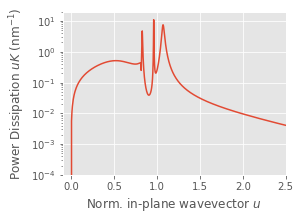

In [9]:
# Plot at 510 nm
with plt.style.context(('ggplot')):
    fig,ax=plt.subplots(figsize=(4,3))
    u = architecture.u
    K_total_array = K_data['K_total']#architecture.K_total_array
    wavelength_to_plot = 510 # nm
    w_idx = np.argmin(np.abs(wavelengths-wavelength_to_plot))
    plt.semilogy(u,u*K_total_array[0,w_idx,:])
    ax.set_xlabel('Norm. in-plane wavevector $u$')
    ax.set_ylabel('Power Dissipation $uK$ (nm$^{-1}$)')
    ax.axis([-0.1,2.5,1e-4,2e1])
    plt.show()

# Angle-dependent EL spectra

In [10]:
architecture.K_total_array = K_data['K_total']
architecture.K_out_array = K_data['K_out']
architecture.thetas = np.arange(0,80.1,10)
architecture.angular_el_spectra()

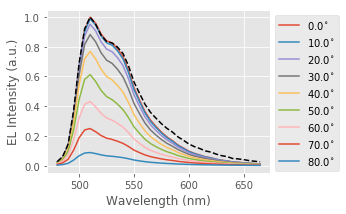

In [11]:
with plt.style.context(('ggplot')):
    fig,ax = plt.subplots(figsize=(4,3))
    for t_idx,theta in enumerate(architecture.thetas):
        plt.plot(architecture.vac_wavelengths,
                 architecture.I_EL[:,t_idx]/np.amax(architecture.I_EL),
                 label=str(theta)+'$^{\circ}$')

    plt.plot(architecture.vac_wavelengths,architecture.pl_spectrum/np.amax(architecture.pl_spectrum),'--k')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('EL Intensity (a.u.)')
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

# Polar Emission Plots

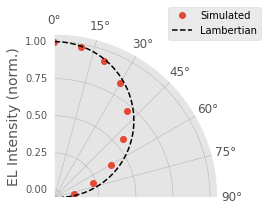

In [12]:
from oledpy.dipole_emission import emission_polar_plot
with plt.style.context(('ggplot')):
    intensity,radiance,luminance = architecture.calc_angular_emission_profile()
    fig,ax,handle,lambertian_handle = emission_polar_plot(
        architecture.thetas,intensity,leg_label='Simulated',theta_range=[0,90],theta_grid_step=15)
    leg=ax.legend(bbox_to_anchor=(1.3,1.2))
    ax.set_ylim(-0.05,1.05)
    ax.grid(color=0.7*np.ones((3,)),linewidth=0.5)
    [ax.spines[i].set_linewidth(0.8) for i in ax.spines] #adjust border width
    plt.savefig('test_polar.png',dpi=300,bbox_inches='tight',bbox_extra_artists=[leg],
               transparent=True)
    plt.show()

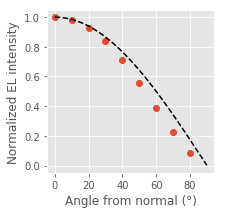

In [13]:
with plt.style.context('ggplot'):
    intensity = np.trapz(architecture.I_EL,architecture.vac_wavelengths,axis=0)
    fig,ax=plt.subplots(figsize=(3,3))
    plt.plot(architecture.thetas,intensity/np.amax(intensity),'o')
    plt.plot(np.arange(0,np.pi/2,0.01)*180/np.pi,
             np.cos(np.arange(0,np.pi/2,0.01)),'--k')
    ax.set_xlabel('Angle from normal (°)')
    ax.set_ylabel('Normalized EL intensity')
    plt.show()

# Spatial Dependence of Outcoupling

In [7]:
# Make deep copy of architecture to preserve previous data
# A deepcopy is a new object and does not link to previous object
import copy
arch2 = copy.deepcopy(architecture)

In [8]:
# Calculate across EML
arch2.set_dipole_positions(np.arange(0,1.01,0.2)) 
arch2.init_pds_variables(custom_u=custom_u)
arch2.summarize_device()

Dipole positions changed. Remember to update RZ
RZ and dipole_positions not same length! Flat RZ will be assumed


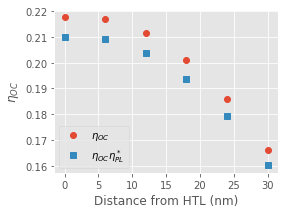

In [16]:
with plt.style.context('ggplot'):
    fig,ax=plt.subplots(figsize=(4,3))
    plt.plot(arch2.dipole_positions*arch2.d[arch2.active_layer],
             arch2.wavelength_averaged_eta_out,'o',label='$\eta_{OC}$')
    plt.plot(arch2.dipole_positions*arch2.d[arch2.active_layer],
             arch2.wavelength_averaged_eta_out*arch2.PLQY_effective_spatial,
             's',label='$\eta_{OC}\eta_{PL}^*$')
    ax.set_xlabel('Distance from HTL (nm)')
    ax.set_ylabel('$\eta_{OC}$')
    plt.legend(loc='lower left')
    plt.show()

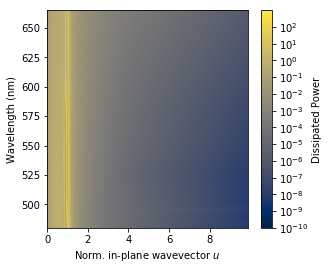

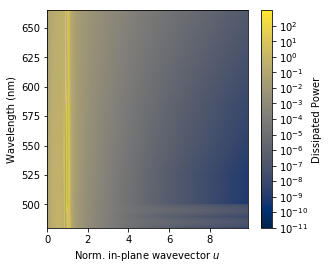

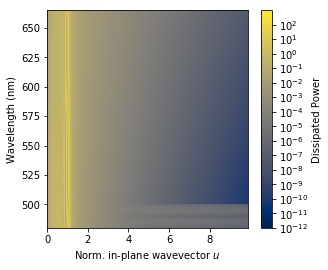

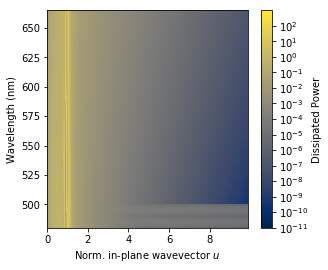

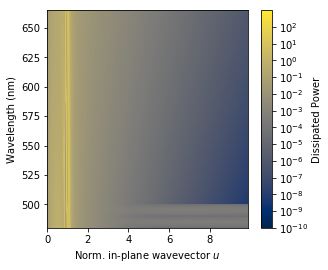

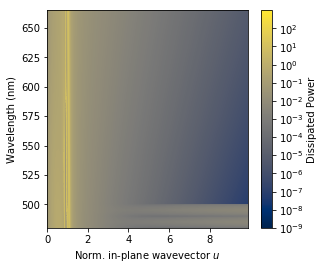

In [18]:
from matplotlib import colors
for z_idx in range(len(arch2.dipole_positions)):
    fig,ax=plt.subplots(figsize=(4.5,4))
    u = arch2.u
    K_total_array = arch2.K_total_array
    z = u*K_total_array[z_idx,:,:]
    lev_exp = np.arange(np.floor(np.log10(z[z>0].min())-1),
                        np.ceil(np.log10(z.max())+1),0.01)
    levs = np.power(10, lev_exp)
    cs = ax.contourf(u,wavelengths, z, levs, 
                norm=colors.LogNorm(),cmap=plt.get_cmap('cividis'))#cividis,#plasma,#viridis
    ticks = 10**np.arange(np.floor(np.log10(z[z>0].min())-1),np.ceil(np.log10(z.max())+1),1)
    cbar = plt.colorbar(cs,ticks=ticks)
    cbar.set_label('Dissipated Power')
    ax.set_xlabel('Norm. in-plane wavevector $u$')
    ax.set_ylabel('Wavelength (nm)')
    plt.show()

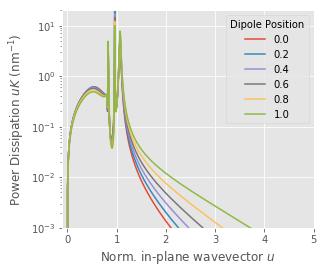

In [24]:
with plt.style.context('ggplot'):
    fig,ax=plt.subplots(figsize=(4.5,4))
    for z_idx in range(len(arch2.dipole_positions)):
        u = arch2.u
        K_total_array = arch2.K_total_array
        wavelength_to_plot = 510 # nm
        w_idx = np.argmin(np.abs(wavelengths-wavelength_to_plot))
        plt.semilogy(u,u*K_total_array[z_idx,w_idx,:],label='{:.1f}'.format(arch2.dipole_positions[z_idx]))
    ax.set_xlabel('Norm. in-plane wavevector $u$')
    ax.set_ylabel('Power Dissipation $uK$ (nm$^{-1}$)')
    ax.axis([-0.1,5,1e-3,2e1])
    plt.legend(title='Dipole Position')
    plt.show()

## Influence of RZ on outcoupling

Flat RZ:
n_OC = 20.1%
Exponential RZ, HTL side:
n_OC = 20.9%
Exponential RZ, ETL side:
n_OC = 19.2%


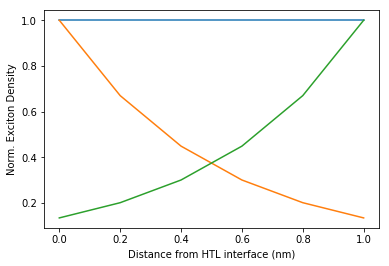

In [26]:
# Compare outcoupling efficiency for different RZ shapes
arch2.set_RZ(np.ones(arch2.dipole_positions.shape))
# Or manually:
# arch2.RZ = np.ones(arch2.dipole_positions.shape)
# arch2.RZ_weights = arch2.RZ / np.trapz(arch2.RZ,arch2.dipole_positions)
arch2.spatially_average_outcoupling()
print("Flat RZ:")
print('n_OC = ' +
      '{:.1f}'.format(arch2.spatially_averaged_eta_out*100)+'%')
plt.plot(arch2.dipole_positions,arch2.RZ)

arch2.set_RZ(np.ones(arch2.dipole_positions.shape)
                    * np.exp(-arch2.dipole_positions/0.5))
# arch2.RZ = (np.ones(arch2.dipole_positions.shape)
#                     * np.exp(-arch2.dipole_positions/0.5))
# arch2.RZ_weights = arch2.RZ / np.trapz(arch2.RZ,arch2.dipole_positions)

arch2.spatially_average_outcoupling()
print("Exponential RZ, HTL side:")
print('n_OC = ' +
      '{:.1f}'.format(arch2.spatially_averaged_eta_out*100)+'%')
plt.plot(arch2.dipole_positions,arch2.RZ)

arch2.set_RZ(np.ones(arch2.dipole_positions.shape)
                    * np.exp(-(1-arch2.dipole_positions)/0.5))
# arch2.RZ = (np.ones(arch2.dipole_positions.shape)
#                     * np.exp(-(1-arch2.dipole_positions)/0.5))
# arch2.RZ_weights = arch2.RZ / np.trapz(arch2.RZ,arch2.dipole_positions)

arch2.spatially_average_outcoupling()
print("Exponential RZ, ETL side:")
print('n_OC = ' +
      '{:.1f}'.format(arch2.spatially_averaged_eta_out*100)+'%')
plt.plot(arch2.dipole_positions,arch2.RZ)
plt.xlabel("Distance from HTL interface (nm)")
plt.ylabel("Norm. Exciton Density")
plt.show()

# Looping over ETL thickness

In [27]:
layer_names = ['SiO2','ITO','PEDOT','TAPC','NPD-Irppy','Alq3',
               'BPhen','Ag','Air']
d = [0,90,60,10,20,10,40,100,0]
doping = [1,1,1,1,[0.92,0.08],1,1,1,1]
active_layer = 4
# Define wavelengths of interest
arch = ThinFilmArchitecture(
    d=d,layer_names=layer_names,doping=doping,active_layer=active_layer,
    dipole_positions=[1],u_step=0.0025,u_stop=2,
    tau=1e-6,PLQY=0.95,
    vac_wavelengths=np.arange(560,670.1,10))#
arch.load_nk(df_nk=df_nk)
arch.init_pds_variables()

Active layer is: NPD-Irppy. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
No PL spectrum provided. Flat (white) emission will be assumed


In [ ]:
arch.show_wavelength_progress_bar=True
layer_idx=6
d_ETL_list=np.arange(10,350.1,5)
loop_data = arch.loop_over_single_layer_prop(
     layer_idx=6,layer_prop_list=d_ETL_list,layer_prop='d')

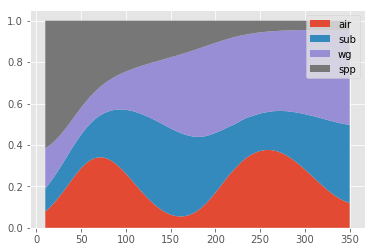

In [29]:
spectrally_integrated_modes = arch.analyze_modes_loop(d_ETL_list,loop_data)
with plt.style.context('ggplot'):
    plt.stackplot(d_ETL_list,spectrally_integrated_modes.T,
                 labels=spectrally_integrated_modes.columns,alpha=1)
    plt.legend()

This approximately reproduces Figure 7b from Furno 2012. Slight differences are likely due to the fact that here we are assuming white emitter emission (and not weighting by the PL spectrum of Ir(MDQ)2(acac)), and also slight optical constant differences

In [ ]:
outcoupling_array=['']*len(d_ETL_list)
eta_out = np.zeros(len(d_ETL_list))
PLQYeff = np.zeros(len(d_ETL_list))
U = np.zeros(len(d_ETL_list))
F = np.zeros(len(d_ETL_list))
U_over_F = np.zeros(len(d_ETL_list))
for d_idx,d_ETL in enumerate(d_ETL_list):
    K_total_array = loop_data['K_total_loop'][d_idx]
    K_out_array = loop_data['K_out_loop'][d_idx]
    outcoupling_array[d_idx]= arch.calc_outcoupled_fraction_array(
        K_total_array,K_out_array)
    arch.outcoupling_array = outcoupling_array[d_idx]
    lam_avg_eta_out,space_avg_eta_out = arch.spatially_average_outcoupling(return_values=True)
    eta_out[d_idx] = lam_avg_eta_out
    arch.K_total_array=K_total_array
    arch.K_out_array=K_out_array
    arch.purcell_factor(tau=1e-6,PLQY=0.9)
    PLQYeff[d_idx] = arch.PLQY_effective_avg
    U[d_idx]=arch.U_avg
    F[d_idx]=arch.F_avg

## Compare to Furno 2012, Fig 7

In [51]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

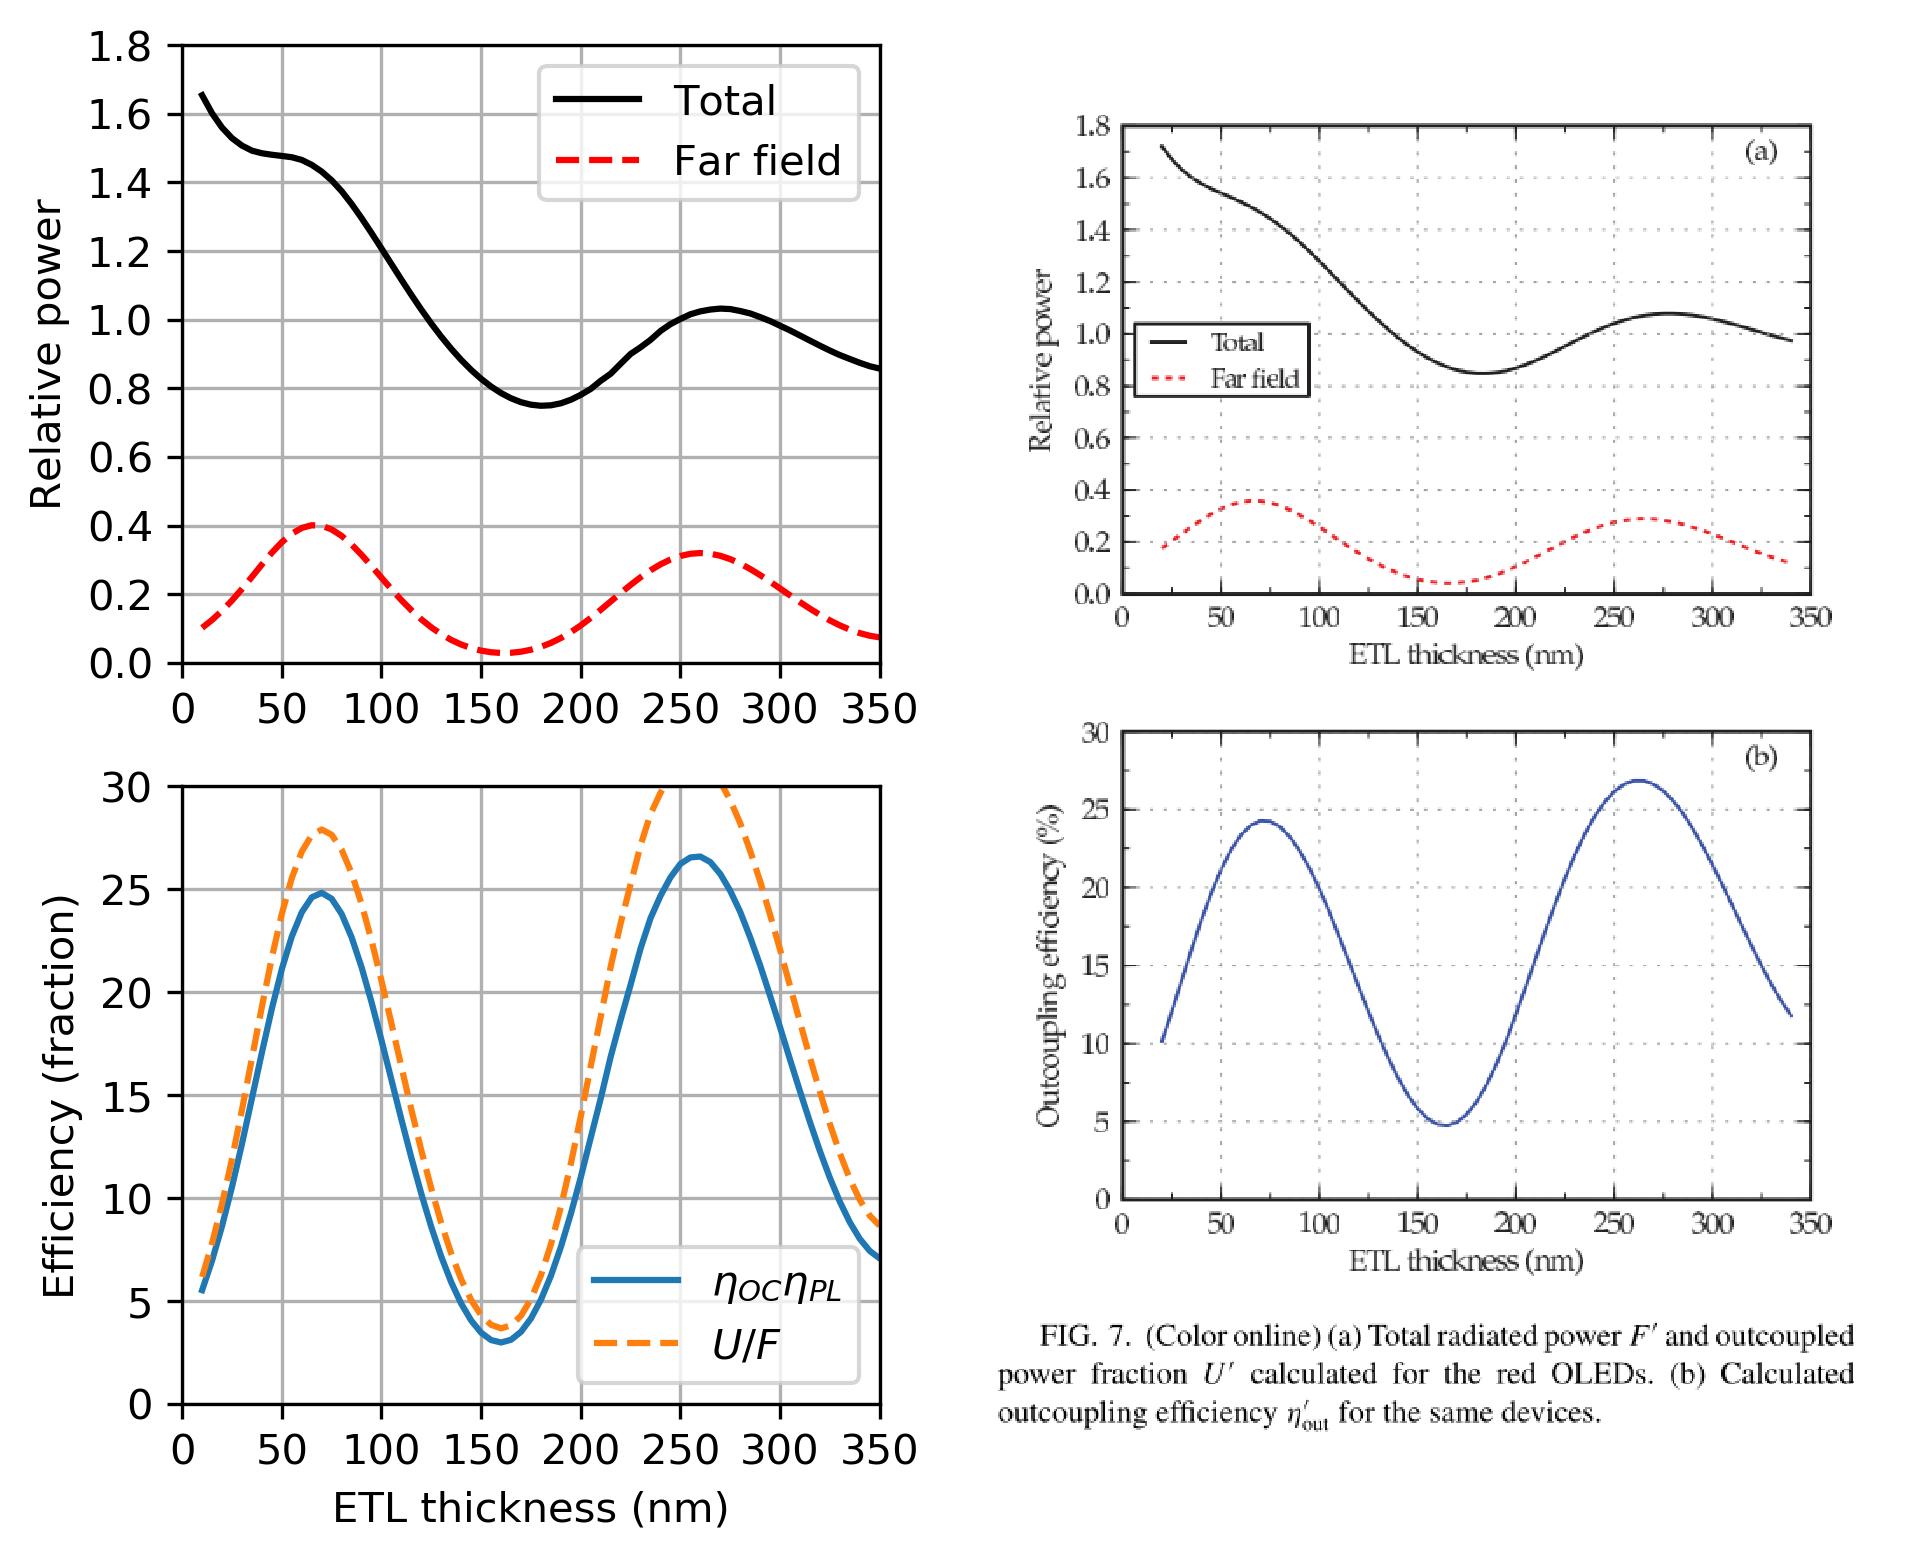

In [54]:
# Compare to Furno 2012
arch.PLQY=0.85
summary = arch.summarize_loop_data(loop_data,layer_idx=6,layer_prop_list=d_ETL_list,layer_prop='d')

fig,ax=plt.subplots(nrows=2,figsize=(3,6))
ax[0].plot(d_ETL_list,summary['F'],'k',label='Total')
ax[0].plot(d_ETL_list,summary['U'],'--r',label='Far field')
ax[0].set_ylabel('Relative power')
#ax[1].plot(d_ETL_list,eta_out*100,'b',label=r'$\eta_{OC}$')
#plt.plot(d_ETL_list,PLQYeff,label=r'$\eta_{PL}$')
ax[1].plot(d_ETL_list,summary['eta_out']*summary['PLQYeff']*100,label=r'$\eta_{OC}\eta_{PL}$')
ax[1].plot(d_ETL_list,summary['U']/summary['F']*100,'--',label='$U/F$')
ax[1].set_xlabel('ETL thickness (nm)')
ax[1].set_ylabel('Efficiency (fraction)')
ax[0].legend()
ax[1].legend()
ax[0].axis([0,350,0,1.8])
ax[1].axis([0,350,0,.3])
ax[0].grid()
ax[1].grid()
ax[0].set_xticks(np.arange(0,350.1,50))
ax[0].set_yticks(np.arange(0,1.81,0.2))
ax[1].set_yticks(np.arange(0,30.1,5))
ax[1].set_xticks(np.arange(0,350.1,50))

# Add comparison image from Furno
im = plt.imread(os.path.join('Reference Data','Furno2012_Fig7.png'))
newax = fig.add_axes([1, 0.1, 1, 1], anchor='SW', zorder=-1)
newax.imshow(im)
newax.axis('off')

plt.show()